In [4]:
import numpy as np 
import sympy as sp
from typing import Tuple
from typing import List
from itertools import permutations

In [6]:
class Flat_layout: 
  def __init__ (self, shape: Tuple[int], stride: Tuple[int]): 
    self.rank = len(shape) 
    assert len(shape) == len(stride)
    self.size = np.prod(shape).item() 
    self.co_size = (np.sum((np.array(shape)-1)*np.array(stride)) + 1).item()
    self.shape = tuple(shape) 
    self.stride = tuple(stride) 
    self.colex_stride = tuple([np.prod(np.array(shape)[0:i]).item() for i in range(0,self.rank)]) #np already defines empty product as 1. 
    self.colex_map = lambda t: sum(tuple(self.colex_stride[i]*t[i] for i in range(self.rank)))
    self.colex_inv_map = lambda x: tuple((x//self.colex_stride[i])%self.shape[i] for i in range(self.rank))
    self.co_ordinate_map = lambda t: sum(tuple(self.stride[i]*t[i] for i in range(self.rank)))
    self.layout_map = lambda x: self.co_ordinate_map(self.colex_inv_map(x))
    
    
    
  def realize(self): 
    self.domain = np.arange(self.size) 
    self.co_ordinate_tensor = np.moveaxis(np.indices(self.shape), 0, -1)
    self.range = np.arange(self.co_size)
    if (not self.shape): 
      self.co_ordinate_map_tensor = np.empty((0,))
      self.layout_map_array = np.empty((0,))
      return
    self.co_ordinate_map_tensor = np.dot(self.co_ordinate_tensor, np.array(self.stride))
    ss_array = np.array(self.colex_stride).reshape(self.rank,1)
    s_array = np.array(self.shape).reshape(self.rank,1) 
    d_array = np.array(self.stride).reshape(self.rank,1)
    self.layout_map_array = np.sum(((self.domain.reshape(1,self.size)//ss_array) % s_array)*d_array, axis = 0)
    
  def __repr__(self): 
    return f"{self.shape}:{self.stride}\n"
  
  def is_compact(self): 
    self.realize()
    if self.size != self.co_size: 
      return False
    injective = np.size(np.unique(self.layout_map_array)) == np.size(self.layout_map_array)
    surjective = np.allclose(np.sort(self.layout_map_array), self.range)
    return injective and surjective
  
  def __eq__ (self, other): 
    shape_equal = self.shape == other.shape 
    stride_equal = self.stride == other.stride 
    return shape_equal and stride_equal

  

    
      

In [7]:

  
def coalesce(layout:Flat_layout): 
  shape = layout.shape 
  stride = layout.stride 
  m = layout.rank
  curr_shape,curr_stride = shape[0], stride[0]
  new_shape, new_stride = [], []
  for i in range(1,m): 
    if stride[i] == curr_shape*curr_stride:
      curr_shape*= shape[i]
    else: 
      new_shape.append(curr_shape)
      new_stride.append(curr_stride)
      curr_shape = shape[i]
      curr_stride = stride[i]
    
  new_shape.append(curr_shape)
  new_stride.append(curr_stride)
  
  return Flat_layout(tuple(new_shape), tuple(new_stride))
       
       
def concat(A:Flat_layout, B:Flat_layout): 
  return Flat_layout(A.shape + B.shape, A.stride + B.stride)    


def permute(A:Flat_layout, perm): 
  assert A.rank == len(perm) 
  m = A.rank
  for i in range(m): 
    assert 0 <= perm[i]
    assert perm[i] < m 
    
  assert np.size(np.unique(np.array(perm))) == np.size(np.array(perm))
  
  perm_shape = tuple(np.array(A.shape)[np.array(perm)].tolist())
  perm_stride = tuple(np.array(A.stride)[np.array(perm)].tolist())
  return Flat_layout(perm_shape, perm_stride) 
   
def squeeze(A:Flat_layout): 
  filter = []
  for i in range(A.rank): 
    if A.shape[i] > 1:
      filter.append(i)
    
  return restrict(A, tuple(filter))
      


def sort(A: Flat_layout): 
  shape = list(A.shape) 
  stride = list(A.stride) 
  m = A.rank 
  for i in range(m): 
    for j in range(i+1, m):
      if stride[i] > stride[j]: 
        stride[i], stride[j] = stride[j], stride[i]
        shape[i], shape[j] = shape[j], shape[i]
        
        
  for i in range(m-1): 
    if stride[i] == stride[i+1] and shape[i] > shape[i+1]: 
      shape[i],shape[i+1] = shape[i+1],shape[i]
      
  return Flat_layout(tuple(shape), tuple(stride))

def restrict(A: Flat_layout, index_subset):
  assert A.rank >= len(index_subset) 
  m = A.rank
  for i in range(len(index_subset)): 
    assert 0 <= index_subset[i]
    assert index_subset[i] < m 
  assert np.size(np.unique(np.array(index_subset))) == np.size(np.array(index_subset))
  
  ids = sorted(index_subset)
  S,D = tuple([A.shape[i] for i in ids]), tuple([A.stride[i] for i in ids])
  return Flat_layout(S,D)

def coal_b(A:Flat_layout): 
  return coalesce(squeeze(A))

def split (A: Flat_layout, split_idx): 
  assert 0 < split_idx 
  assert split_idx < A.rank-1 
# Use .tolist() to convert numpy array slices to python lists of ints first
  sA = tuple(A.shape[0:split_idx])
  sB = tuple(A.shape[split_idx:])

  dA = tuple(A.stride[0:split_idx])
  dB = tuple(A.stride[split_idx:])
  return Flat_layout(sA,dA), Flat_layout(sB,dB)

def get_CS(shape): 
  stride_temp = tuple([1 for _ in range(len(shape))])
  return Flat_layout(shape, stride_temp).colex_stride 

In [8]:
print(190//2)

95


In [9]:
shape = (1,7,3,1,3,5,3,2)
stride = (4,3,4,12,2,2,10,30)
shape_ = (4,7,2,5,8)
stride_ = (60,4,5,10,2)
A = Flat_layout(shape, stride)
B = Flat_layout(shape_, stride_)

In [10]:
"""we shall demonstrate idempotency of operations

"""
print(squeeze(squeeze(A)) == squeeze(A))
print(sort(sort(A)) == sort(A))
print(coal_b(coal_b(A)) == coal_b(A))

True
True
True


In [11]:
#we have squeeze(coal_b(A)) = coal_b(squeeze(A)) = coal_b(A) which is trivial to prove. 
print(squeeze(coal_b(A)) == coal_b(A))

True


In [12]:
print(squeeze(concat(A,B)) == concat(squeeze(A), squeeze(B)))

True


In [13]:
print(coal_b(concat(A,B)))


(7, 3, 3, 120, 7, 10, 8):(3, 4, 2, 2, 4, 5, 2)



In [14]:
#let us make a large column major layout, permute it and split it in two and inspect certain things 

S = (3,4,7,10,5,9,2)
D = get_CS(S)

Col_S = Flat_layout(S,D)

perm = (1,0,3,5,4,2,6)
col_S_perm = permute(Col_S, perm)
LA,LB = split(col_S_perm, 3)

In [15]:
D

(1, 3, 12, 84, 840, 4200, 37800)

In [16]:
print(LA)
print(LB)

(4, 3, 10):(3, 1, 84)

(9, 5, 7, 2):(4200, 840, 12, 37800)



In [17]:
print(sort(LA))
print(sort(LB))

(3, 4, 10):(1, 3, 84)

(7, 5, 9, 2):(12, 840, 4200, 37800)



In [18]:
sorted_LA = sort(squeeze(LA))
print(sorted_LA)
for i in range(sorted_LA.rank-1): 
  print(f"does si*di divide d_i+1 {(sorted_LA.stride[i+1]) % (sorted_LA.shape[i]*sorted_LA.stride[i]) == 0}")

(3, 4, 10):(1, 3, 84)

does si*di divide d_i+1 True
does si*di divide d_i+1 True


In [19]:
sorted_LB = sort(squeeze(LB))
print(sorted_LB)
for i in range(sorted_LB.rank-1): 
  print(f"does si*di divide d_i+1 {(sorted_LB.stride[i+1]) % (sorted_LB.shape[i]*sorted_LB.stride[i]) == 0}")

(7, 5, 9, 2):(12, 840, 4200, 37800)

does si*di divide d_i+1 True
does si*di divide d_i+1 True
does si*di divide d_i+1 True


In [26]:
L = Flat_layout((5,2,5,3), (1,5,10,50))

In [27]:
L.realize()

In [29]:
L.co_ordinate_map_tensor[:,1,:,2]

array([[105, 115, 125, 135, 145],
       [106, 116, 126, 136, 146],
       [107, 117, 127, 137, 147],
       [108, 118, 128, 138, 148],
       [109, 119, 129, 139, 149]])

In [30]:
L.co_ordinate_map_tensor

array([[[[  0,  50, 100],
         [ 10,  60, 110],
         [ 20,  70, 120],
         [ 30,  80, 130],
         [ 40,  90, 140]],

        [[  5,  55, 105],
         [ 15,  65, 115],
         [ 25,  75, 125],
         [ 35,  85, 135],
         [ 45,  95, 145]]],


       [[[  1,  51, 101],
         [ 11,  61, 111],
         [ 21,  71, 121],
         [ 31,  81, 131],
         [ 41,  91, 141]],

        [[  6,  56, 106],
         [ 16,  66, 116],
         [ 26,  76, 126],
         [ 36,  86, 136],
         [ 46,  96, 146]]],


       [[[  2,  52, 102],
         [ 12,  62, 112],
         [ 22,  72, 122],
         [ 32,  82, 132],
         [ 42,  92, 142]],

        [[  7,  57, 107],
         [ 17,  67, 117],
         [ 27,  77, 127],
         [ 37,  87, 137],
         [ 47,  97, 147]]],


       [[[  3,  53, 103],
         [ 13,  63, 113],
         [ 23,  73, 123],
         [ 33,  83, 133],
         [ 43,  93, 143]],

        [[  8,  58, 108],
         [ 18,  68, 118],
         [ 28,  78

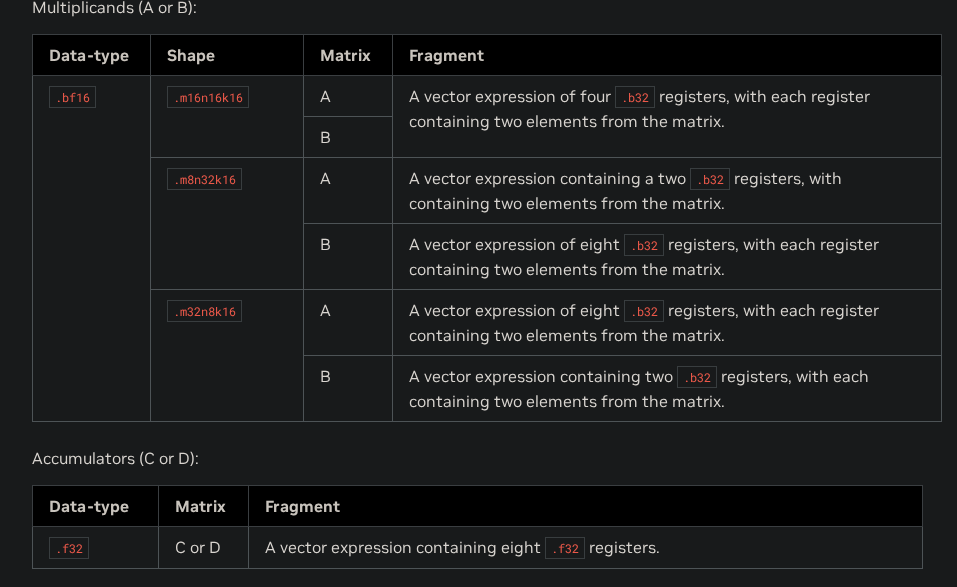

In [ ]:
"""
let us try to understand the wmma fragments using tv layouts. 
so take type .bf16, and shape m16n16k16 
each threads hold a vector expression of 4 .b32, that is some (4,2) shaped .b16 elements, 
you know what fuck this shit 
lets to hopper TV layouts instead. 
"""

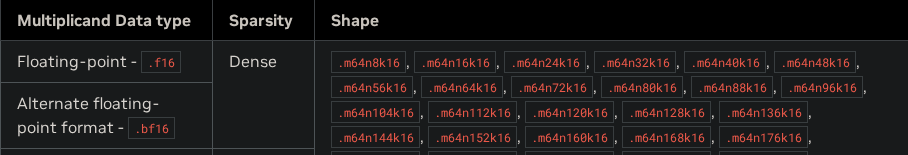

In [ ]:
"""
indeed we are dealing with .bf16, f32 accumulator, and we have problem shape (64,N,16)
so what is the layout of register fragments for A? well A shape is fixed at (64,16) so only one way to do it
also we have warp group, so 4 warps, lets see. 
at the granularity of warpgroup (see picture below) for A matrix, each warp holds a 16,16 chunk 
so imagine my layout is A = (64,16):(16,1) (row major) then we need to tile it with the layout (4:1)

"""

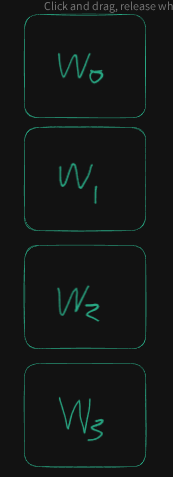